## A comparison of data augmentation and transformation invariance on a simple data set.

In [1]:
import numpy as np
from keras.models import Sequential, Model;
from keras.layers import Dense
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import time
%matplotlib inline

from ti_pooling import transformation_invariant
from ti_pooling.transformations import SymmetricGroup

Using TensorFlow backend.


In [2]:
N = 10000
hidden_units = 10
epochs = 25
eps = 1.0
seed = 1

Generate data sampled from a 3D gaussian and apply the function $f(x_1, x_2, x_3) = \max(x_1, x_2, x_3)$ perturbed by some gaussian noise.

In [3]:
np.random.seed(seed)
X = np.random.normal(size=3*N).reshape(N,3)
y = X.max(axis=1) + np.random.normal(scale=eps, size=N)

Try to learn the function $f$ via a vanilla neural networked with 10 hidden units.

In [4]:
np.random.seed(seed)
vanilla = Sequential()
vanilla.add(Dense(hidden_units, activation='relu', input_shape=X.shape[1:]))
vanilla.add(Dense(1, activation='linear'))
vanilla.compile(loss='mse', optimizer='adam')
tic = time.time()
vanilla_hist = vanilla.fit(X, y, epochs=epochs, verbose=0)
vanilla_time = time.time() - tic
print('Training time:', vanilla_time)
print('Performance:', vanilla.evaluate(X, y, verbose=0))

Training time: 6.393365383148193
Performance: 1.0161263989448548


Using our domain knowledge or information obtained from data expoloration, we may expect that our function $f$ is invariant under permutation of the input features. Equivalently, $f$ is invariant under the action of the symmetric group $S_3$ in the sense that $f(x_1, x_2, x_3) = f(x_{1\sigma}, x_{2\sigma}, x_{3\sigma})$ for all $\sigma \in S_3$.

In [5]:
s3 = SymmetricGroup()
print('Transformations of (1, 2, 3) under the action of S3:', [tuple(x[0]) for x in s3.transform(np.array([[1,2,3]]))])

Transformations of (1, 2, 3) under the action of S3: [(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]


A common trick for helping neural networks learn such invariances is *data augmentation*: training our network on all transformations of the original feature set. We now train the same vanilla neural network on this augmented data set.

In [6]:
np.random.seed(seed)
aug_X = np.vstack(s3.transform(X))
aug_y = np.tile(y, s3.num_transformations(X.shape[1:]))
augmented = Sequential()
augmented.add(Dense(hidden_units, activation='relu', input_shape=X.shape[1:]))
augmented.add(Dense(1, activation='linear'))
augmented.compile(loss='mse', optimizer='adam')
tic = time.time()
augmented_hist = augmented.fit(aug_X, aug_y, epochs=epochs, verbose=0)
augmented_time = time.time() - tic
print('Training time:', augmented_time)
print('Performance:', augmented.evaluate(X, y, verbose=0))

Training time: 37.11271262168884
Performance: 1.0135574721336365


A more sophisicated approach is to implement a *transformation-invariant pooling layer* across a set of siamese networks.

In [7]:
np.random.seed(seed)
network = Sequential()
network.add(Dense(hidden_units, activation='relu', input_shape=X.shape[1:]))
network.add(Dense(1, activation='linear'))
inputs, output = transformation_invariant(network, s3)
ti_network = Model(inputs=inputs, outputs=output)
ti_network.compile(loss='mse', optimizer='adam')
tic = time.time()
ti_network_hist = ti_network.fit(s3.transform(X), y, epochs=epochs, verbose=0)
ti_network_time = time.time() - tic
print('Training time:', ti_network_time)
print('Performance:', ti_network.evaluate(s3.transform(X), y, verbose=0))

Training time: 9.659552335739136
Performance: 1.0041161907196046


Graphing the MSE loss of our networks per epoch, we see that all three networks eventually approach the Bayes' error. However, the network trained on the augmented data and the transformation invariant network converge a lot faster than the vanilla network. If we plot the loss against the training time rather than the epoch, we see the transformation invariant network converges the fastest, as the augmented network requires a lot more computational resources.

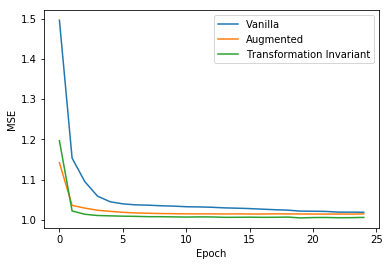

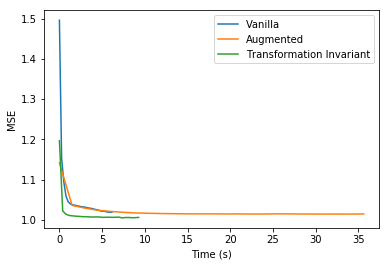

In [8]:
plt.figure()
plt.plot(vanilla_hist.history['loss'])
plt.plot(augmented_hist.history['loss'])
plt.plot(ti_network_hist.history['loss'])
plt.legend(['Vanilla', 'Augmented', 'Transformation Invariant'])
plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.figure()
plt.plot(np.array(vanilla_hist.epoch)*vanilla_time/epochs, vanilla_hist.history['loss'])
plt.plot(np.array(augmented_hist.epoch)*augmented_time/epochs, augmented_hist.history['loss'])
plt.plot(np.array(ti_network_hist.epoch)*ti_network_time/epochs, ti_network_hist.history['loss'])
plt.legend(['Vanilla', 'Augmented', 'Transformation Invariant'])
plt.xlabel('Time (s)')
plt.ylabel('MSE');

Finally, to check we are not overfitting our data set, we check our performance on a test set is close to the Bayes' error.

In [9]:
test_seed = 2018 # Need a different seed to avoid getting points in training set
np.random.seed(2018) 
test_N = 10000
test_X = np.random.normal(size=3*test_N).reshape(test_N,3)
test_y = test_X.max(axis=1) + np.random.normal(scale=eps, size=test_N)
print(vanilla.evaluate(test_X, test_y, verbose=0))
print(augmented.evaluate(test_X, test_y, verbose=0))
print(ti_network.evaluate(s3.transform(test_X), test_y, verbose=0))

1.0176131589889525
1.0147902126312256
1.0072099172592164
